In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

/Users/joseongho/Library/Python/3.9/lib/python/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/joseongho/Library/Python/3.9/lib/python/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/joseongho/Library/Python/3.9/lib/python/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORT

In [2]:
trainDF = pd.read_csv('train.csv')
testDF = pd.read_csv('test.csv')
concatDF = pd.concat([trainDF,testDF])
concatDF = concatDF.reset_index(drop=True)


print(concatDF.info())
concatDF.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB
None


,id,keyword,location,text,target
3616,5162,fatalities,NaN,EXCLUSIVE: In 179 fatalities involving on-duty...,1.0


In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, DF:pd.DataFrame):
        if 'target' in DF.columns:
            self.target= DF['target'].values
        else:
            self.target= DF['id'].values
        self.text = DF['text'].values
        self.id= DF['id'].values
        pass

    def __len__(self):
        return len(self.id)

    def __getitem__(self, idx):
        text = self.text[idx]
        target = self.target[idx]

        return target, text


trainSet= MyDataset(DF=trainDF)
testSet= MyDataset(DF=testDF)
trainSet[0]

(1, 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

In [4]:
myTokenizer = get_tokenizer('basic_english')
token = myTokenizer('hello my wolrd')
token

['hello', 'my', 'wolrd']

In [5]:
def yield_tokens(myIter):
    for  _ , text in myIter:
        yield  myTokenizer(text)


yield_tokens(iter(trainSet))

<generator object yield_tokens at 0x15be297b0>

In [6]:
vocab = build_vocab_from_iterator(yield_tokens(iter(trainSet)), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])
vocab(['Our', 'Deeds', 'are', 'the', 'Reason', 'of'])

[0, 0, 30, 4, 0, 10]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
trainSet, valSet = torch.utils.data.dataset.random_split(
    dataset=trainSet,lengths=[0.8,0.2]
)
trainSet[0]

(0,
 '@InfiniteGrace7 I just screamed to the world how much I love My Little Pony ??')

In [9]:
def myCollate(batch):
    labelList = []
    textList=[]
    offset=[0]
    for label, text in batch:
        labelList.append(label)

        text = vocab(myTokenizer(text))
        text = torch.tensor(text)
        textList.append(text)

        offset.append(text.size(0))

        
    labelList = torch.tensor(labelList)

    textList= torch.cat(textList)

    offset = offset[:-1]
    offset = torch.tensor(offset)
    offset = offset.cumsum(dim=0)


    return labelList.to(device), textList.to(device), offset.to(device), 

trainLoader = torch.utils.data.DataLoader(dataset=trainSet,batch_size=10,sampler=torch.utils.data.RandomSampler(trainSet), collate_fn=myCollate)
valLoader = torch.utils.data.DataLoader(dataset=valSet,collate_fn=myCollate)
testLoader = torch.utils.data.DataLoader(dataset=testSet,collate_fn=myCollate)

next(iter(trainLoader))

(tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0]),
 tensor([ 7529,  5880,   665,    25,   893,  4319,    83,     3,     2,     1,
         13601,     3,     2,     1, 15600,  5736,    96,     8,     4,  5814,
           489,     1,    94,   853,     5,    27,   170,    24,  3643,     1,
            77,     5,    27,   467,  1042,   299,     1,  7604,  1830,  1908,
          4572,  5677,   698,     1,    33,     7,   171,    83,     3,     2,
             1, 14182,     3,     2,     1, 14564, 10492,   114,   103,    20,
            14,     4,  8439,    37,    52,    70,  1168,     9,   490,    20,
            12,     4,  1611,   210,  1593,    16,    26,   695,    18,     4,
           987,  7814,  3326, 20780,   223,    10,     4,  2671,    10,   189,
          2280,    25,     4,   962,    24, 11419,     1,     1,     1, 23490,
             7,  1264, 17939,    20,   485,  2610,     4, 23295,     1,   539,
          2551,  1076,    41,   625,    51, 22354,   431,    10,    91,   308,
           

In [10]:
class myModel(torch.nn.Module):
    def __init__(self, vocabSize, embeddingDim, classCnt) -> None:
        super().__init__()
        self.embadding=torch.nn.EmbeddingBag(vocabSize, embeddingDim)
        self.linear = torch.nn.Linear(embeddingDim, classCnt)

    def forward(self,text, offset ):
        logits = self.embadding(text,offset)
        logits = self.linear(logits)
        return logits

model = myModel(len(vocab),1,2).to(device)

label, text, offset= next(iter(trainLoader))
model(text, offset )

tensor([[-0.8448,  0.1732],
        [-0.9140, -0.0475],
        [-0.8308,  0.2178],
        [-0.8335,  0.2093],
        [-0.8260,  0.2333],
        [-0.8598,  0.1254],
        [-0.8692,  0.0953],
        [-0.8252,  0.2358],
        [-0.8853,  0.0439],
        [-0.8527,  0.1481]], grad_fn=<AddmmBackward0>)

0 0.5650459921156373 1040.0678516924381 419.4342921972275
1 0.5670170827858082 1047.9004332125187 417.0303824841976
2 0.561760840998686 1037.9073225557804 416.69877964258194
3 0.5683311432325887 1038.3732166290283 416.2033078074455
4 0.5611038107752957 1038.6897189766169 414.8847402334213
5 0.573587385019711 1025.6394927054644 412.9615856409073
6 0.580814717477004 1020.4665093868971 409.9551328718662
7 0.5847568988173456 1024.1786311157048 405.1546404659748
8 0.6005256241787122 1000.7355560362339 400.82323083281517
9 0.6103810775295664 1000.2870289124548 396.90432676672935
10 0.6090670170827858 997.8055178336799 394.5695151388645
11 0.6169513797634691 979.9254149086773 390.5773931890726
12 0.6307490144546649 974.0152072496712 388.86055332422256
13 0.6346911957950065 972.077460296452 386.9325089752674
14 0.6307490144546649 980.0575450882316 383.9533674418926
15 0.628777923784494 965.9487898945808 383.369221419096
16 0.6340341655716163 961.0113519839942 381.11880174279213
17 0.6478318002

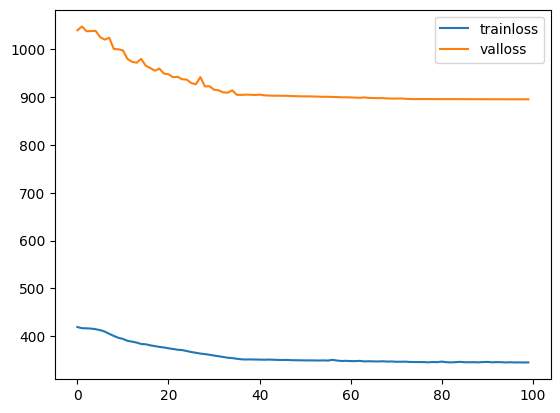

In [11]:
lossFunc = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1)
lrScheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)

def train(dataLoader,model, lossFunc, optim):
    model.train()
    trainLoss = 0
    for label, text, offset in dataLoader:
        optim.zero_grad()

        logits = model(text, offset)
        loss = lossFunc(logits, label)

        trainLoss += loss.item()

        loss.backward()
        optim.step()

    return trainLoss

def val(dataLoader,model, lossFunc):
    model.eval()
    valLoss = 0
    accuracy = 0
    with torch.no_grad():
        for label, text, offset, in dataLoader:
            logits = model(text, offset)
            loss = lossFunc(logits, label)

            accuracy += (logits.argmax(1) == label).sum().item()
            valLoss += loss.item()

    return valLoss, accuracy/len(dataLoader)

bestLoss = float('inf')
trainlossList=[]
vallossList=[]
bestModel=model

for epoch in range(100):
    trainLoss = train(trainLoader,model, lossFunc, optim)
    valLoss, accuracy= val(valLoader,model, lossFunc)
    trainlossList.append(trainLoss)
    vallossList.append(valLoss)
    print(f'{epoch} {accuracy} {valLoss} {trainLoss}')

    if valLoss >bestLoss:
        lrScheduler.step()
        model = bestModel
    else:
        bestLoss = valLoss
        bestModel = model

plt.plot(trainlossList, label='trainloss')
plt.plot(vallossList, label='valloss')
plt.legend()

In [12]:
plt.close()

In [13]:
def test(dataLoader,model):
    model.eval()
    result = []

    with torch.no_grad():
        for id, text, offset in dataLoader:
            logits = model(text, offset)
            result.append([id.item(), logits.argmax().item()])


    return  result

result = test(testLoader, bestModel)
resultDF = pd.DataFrame(result).rename(columns={0:'id',1:'target'})
resultDF

,id,target
0,0,1
1,2,1
2,3,0
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [14]:
resultDF.to_csv('sample_submission.csv', index=False)